In [19]:
from facenet_models import FacenetModel
import numpy as np
import cv2
import os
import camera
import pickle
import matplotlib.pyplot as plt
model = FacenetModel()

In [20]:
def count_faces(inland):
    thresh = 0.63
    duplicates = 0
    for i in range(inland.shape[0]):
        for j in range(i + 1, inland.shape[0]):
            if cos_dist(inland[i], inland[j]) < thresh:
                duplicates += 1
                break
    return inland.shape[0] - duplicates

In [21]:
def cos_dist(a, b):
    x = a / np.linalg.norm(a)
    y = b / np.linalg.norm(b)
    return 1 - np.dot(x, y)

In [22]:
def folder_face_read(folder):
    members = []
    current = ""
    mem = None
    for fname in os.listdir(folder):
        if fname[0] == '.': continue
        name = fname[:-5]
        if current != name:
            members.append(mem)
            mem = Member(name)
            current = name
        pic = cv2.imread(folder + '\\' + fname)[:, :, ::-1]
        for i in model.compute_descriptors(pic, model.detect(pic)[0]):
            mem.add_face(i)
    members.append(mem)
    return members[1:]

In [23]:
class Member():
    
    def __init__(self, name):
        
        self.name = name
        self.faces = []
        
    def add_face(self, face):
        self.faces.append(face)
        
    def avg_face(self):
        return np.mean(self.faces, axis=0)
    
    def compare_to(self, face):
        return cos_dist(face, self.avg_face())

In [24]:
class Recognizer():
    
    def __init__(self, folder):
        self.database = folder_face_read(folder)
        
    def recognize(self, face):
        
        minimum = 1
        ret = None
        
        for i in self.database:
            dist = i.compare_to(face)
            if dist < minimum:
                ret = i
                minimum = dist
                
        return ret.name

In [26]:
read = True

if not read:
    from time import time
    start = time()
    main = Recognizer("img_src")
    with open("dataface.pkl", "wb") as file:
        pickle.dump(main, file)
    print("model trained in ", time()-start, "s")
        
else:
    with open("dataface.pkl", "rb") as file:
        main = pickle.load(file)

In [27]:
def show_image_with_recognition(image, main, cutoff=1.0):

    from matplotlib.patches import Rectangle
    
    detections, _, _ = model.detect(image)
    descriptors = model.compute_descriptors(image, detections)
    
    matches = [main.recognize(face.reshape(512)) for face in descriptors]
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    for name, det in zip(matches, detections):
        l, t, r, b = det
        x, y = l, b
        width = r - l
        height = t - b

        rect = Rectangle((x, y), width, height, fill=None, color="red", lw=1)
        ax.add_patch(rect)
        if name is not None:
            ax.text(x + 0.1, y + 16.1, name, fontsize=10, color="white")
    return fig, ax, matches, detections, descriptors

No camera config found, using defaults
	 port=0, exposure=0.7


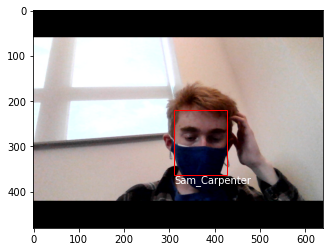

In [28]:
img = camera.take_picture()
fig, ax, matches, detections, descriptors = show_image_with_recognition(img, main)